<center>

*******************************************************************************************

### Kuramoto *r*

##### 1 May 2025

##### Juan Ignacio Mendoza Garay

*******************************************************************************************

</center>

##### INFORMATION:

* The Kuramoto order parameter *r* measures phase coherence (closeness) amongst two or more oscillators.
>
* Tested with:
    * Python 3.11
    * Windows 11
>
* References:
    * Strogatz, S. H. (2000). From Kuramoto to Crawford: exploring the onset of synchronization in populations of coupled oscillators. *Physica D: Nonlinear Phenomena, 143*(1-4), 1-20.
    * https://github.com/fabridamicelli/kuramoto
>
* Instructions:
    * Edit the values indicated with an arrow like this: <---

*******************************************************************************************

In [1]:
import sys
import numpy as np

sys.path.append('../src')
import syncoord as sc

***
### Generate synthetic data

index; key; Name; duration (s):
  0; 0; Test Data; 0:16.0


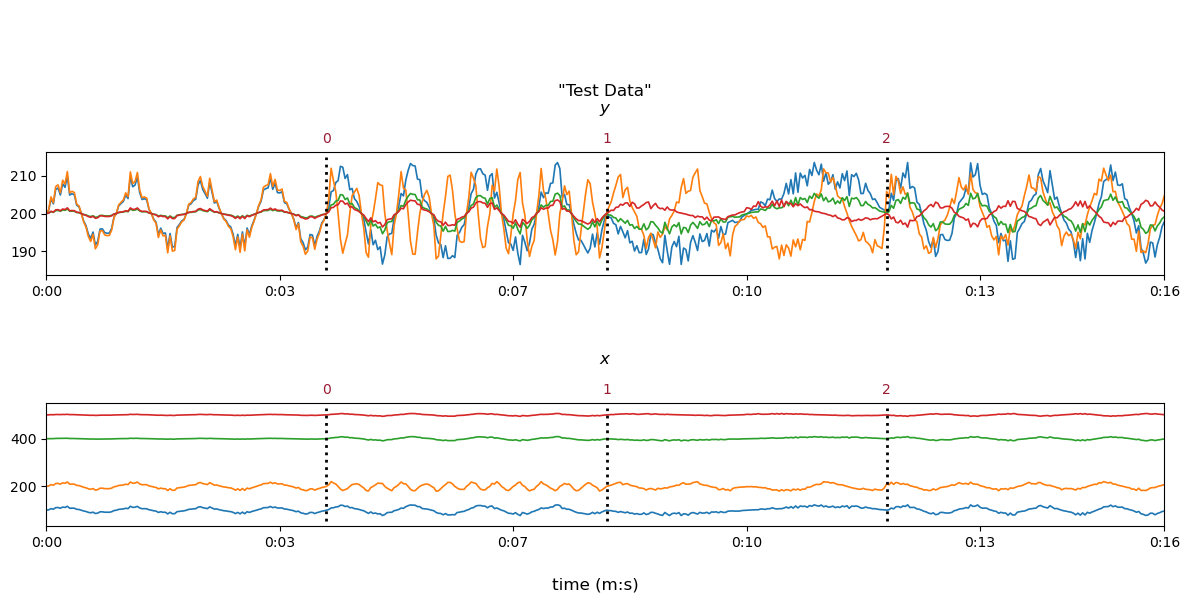

In [2]:
position = sc.ptdata.load( 'make', seed=1, print_info=True )
position.visualise( vscale=1.2, dlattr='1.2' )

***
### Low-Pass Filter

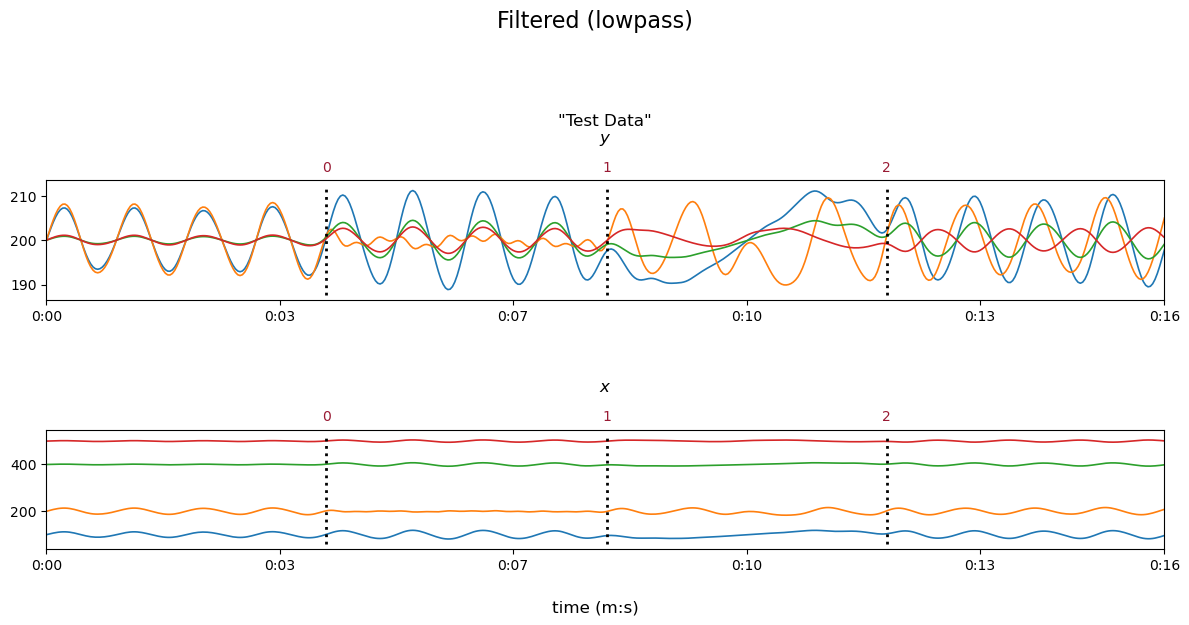

In [3]:
apply_LPF = True # <---

filter_cutoff_freq = 2 # <--- (Hz)
filter_order = 3       # <---

if apply_LPF:
    filtered = sc.ptdata.smooth( position, filter_type='butter', freq_response='lowpass',
                                 cutoff_freq=filter_cutoff_freq, order=filter_order )
    filtered.visualise( vscale=1.2, dlattr='1.2'  )
else:
    filtered = position
    print('Filter not applied.')

***
### Speed

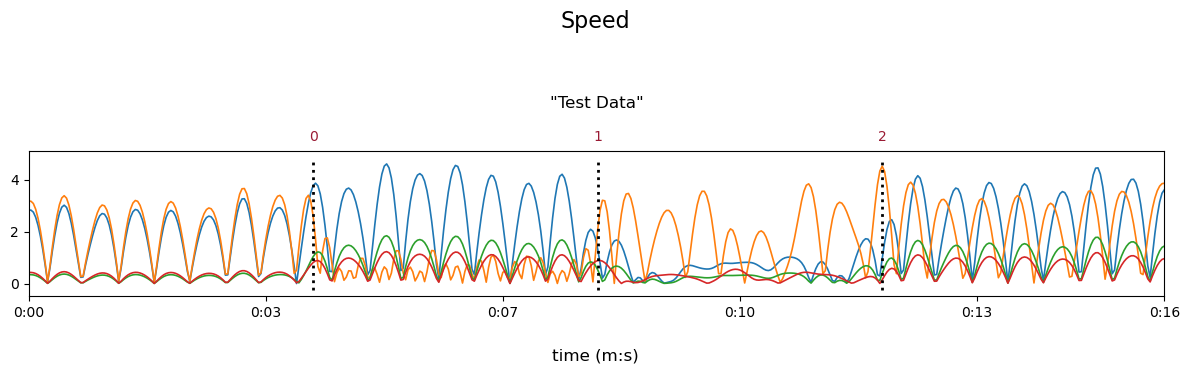

In [4]:
speed = sc.ptdata.tder2D( filtered )
speed.visualise( vscale=1.4, dlattr='1.2' )

***
### Multiband Kuramoto Order Parameter *r* using FFT phase

>
#### FFT Phase

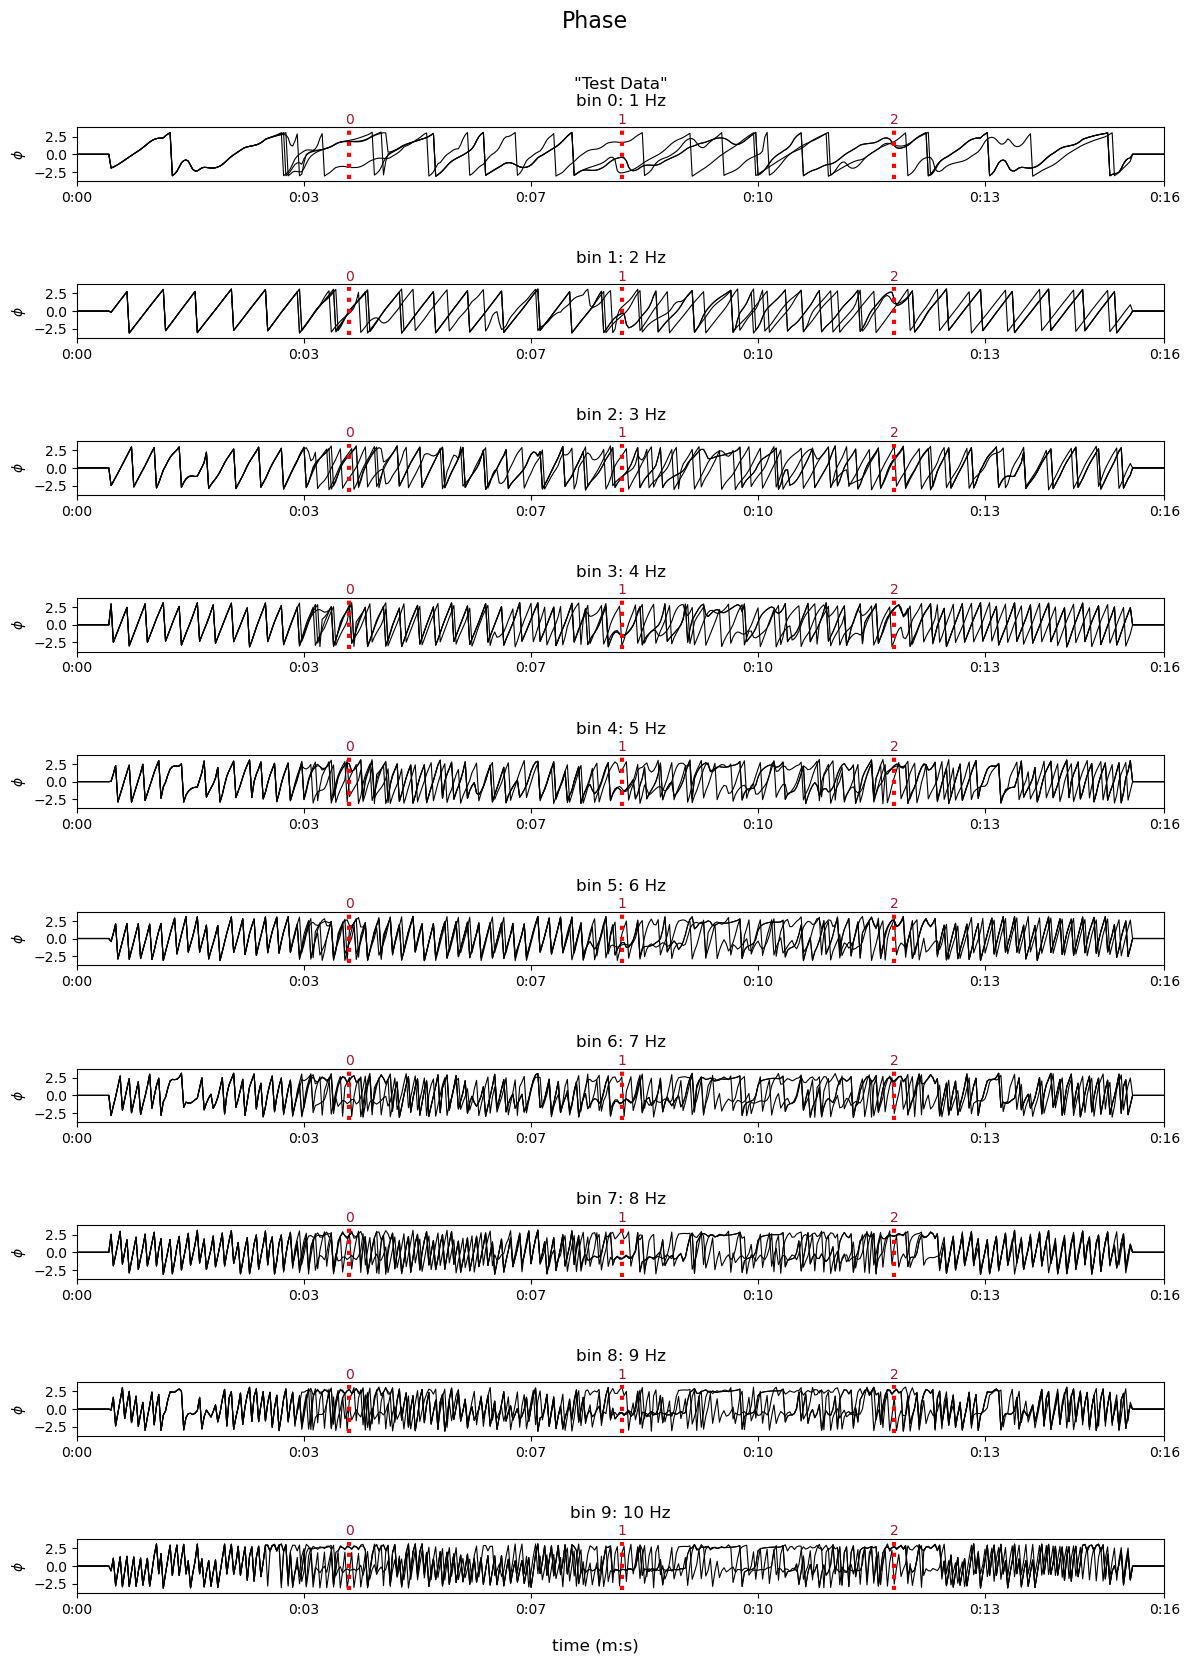

In [5]:
fft_window_s = 1           # <--- FFT window's length (seconds)
sel_freq_bin = slice(0,10) # <--- select frequency bins (int, slice, or 'all')

fft_phase = sc.ptdata.fourier( speed, fft_window_s, output='phase' )
if sel_freq_bin == 'all':
    fft_phase.visualise( vscale=0.7 )
else:
    fft_phase = sc.ptdata.select(fft_phase,frequency=sel_freq_bin)
    if isinstance(sel_freq_bin,slice): fft_phase.visualise( vscale=0.7 )
    else: fft_phase.visualise( vscale=1.3 )

>
#### Kuramoto *r*

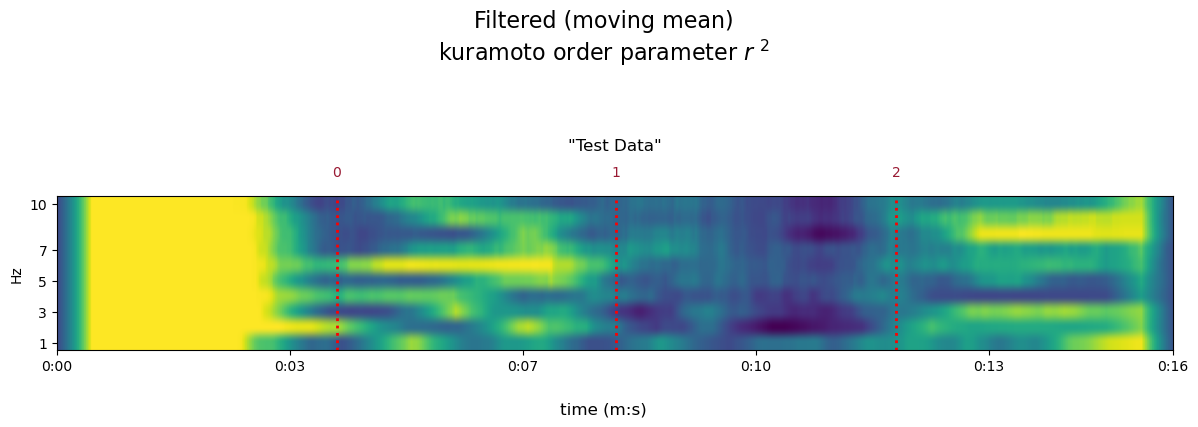

In [6]:

smooth_power = True  # <---

kr_fft = sc.ptdata.kuramoto_r( fft_phase )
kr_fft_vis = kr_fft
if smooth_power:
    kr_fft_s = sc.ptdata.smooth( kr_fft, filter_type='mean', window_size=1 )
    kr_fft_p = sc.ptdata.apply( kr_fft_s, np.power, 2 )
    kr_fft_vis = kr_fft_p
kr_fft_vis.visualise( vscale=1.5 )

>
#### Average for group

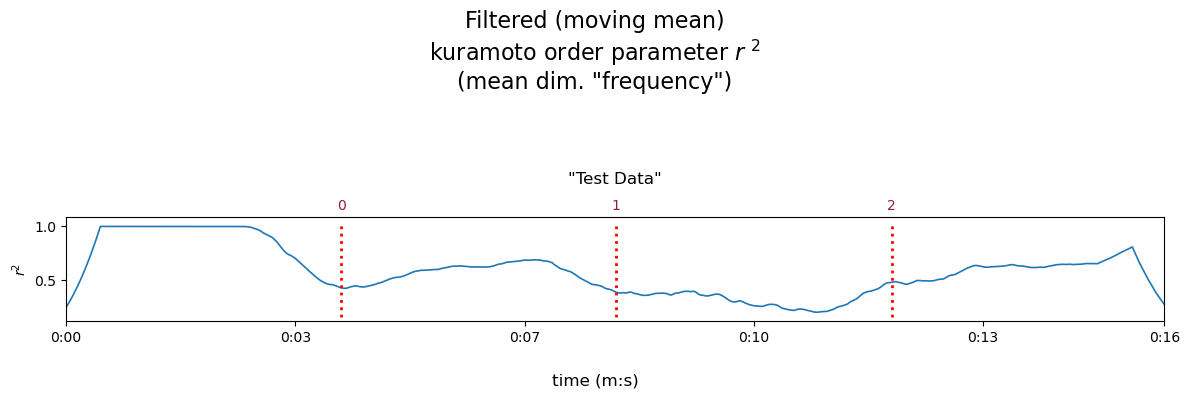

In [7]:
kr_fft_aggr_top = sc.ptdata.aggrax( kr_fft_vis, axis=0, function='mean' )
kr_fft_aggr_top.visualise( vscale=1.3, vistype='line', dlattr='1.2' )

>
#### Sections' statistics

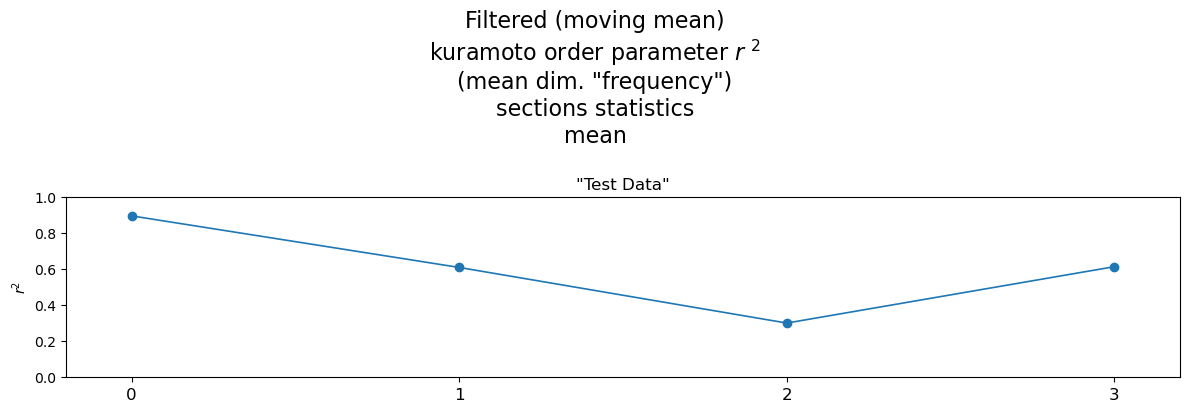

In [8]:

sec_margins = [[0,0.5],[0.5,0.5],[0.5,0.5],[0.5,0]] # <--- sections' margins (seconds)

kr_fft_aggr_top_stats = sc.ptdata.secstats( kr_fft_aggr_top, margins=sec_margins, last=True )
kr_fft_aggr_top_stats.visualise( statistics='mean', vscale=1.2 )

import matplotlib.pyplot as plt
plt.ylim((0,1))
plt.xlim((-0.2,3.2))
plt.xticks((0,1,2,3),('0','1','2','3'),fontsize=12);

***
### Multiband Kuramoto Order Parameter *r* using peaks phase

>
#### Peaks phase

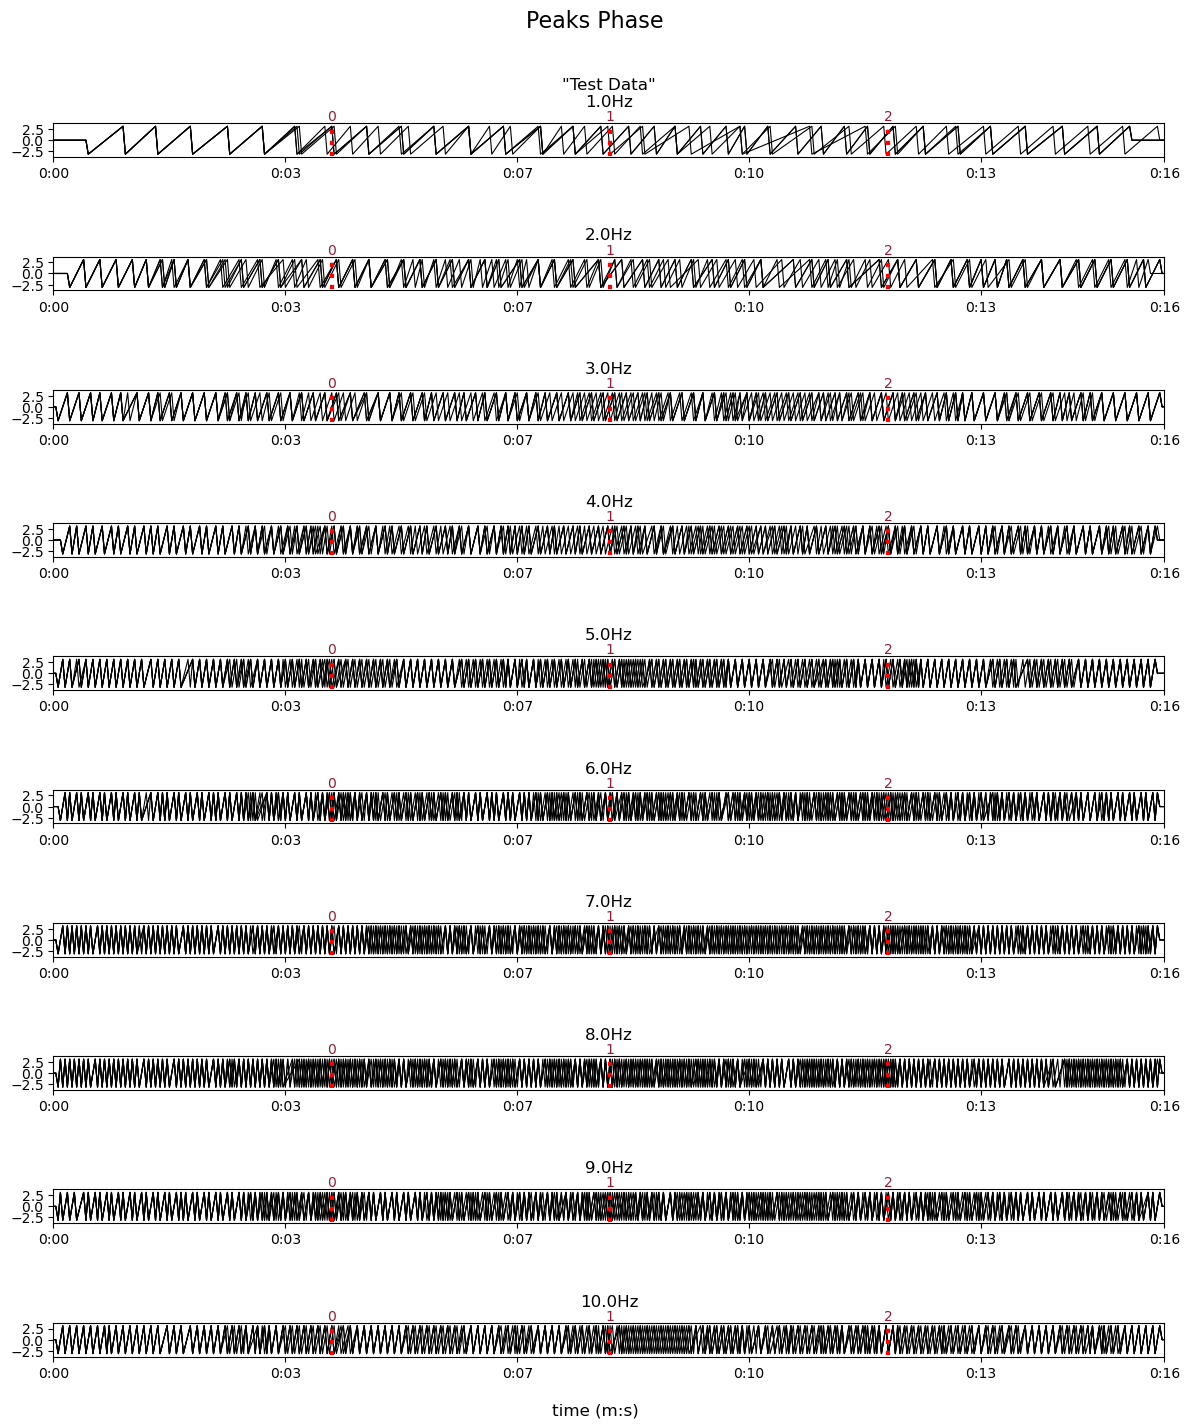

In [14]:
filter_type = 'butter'                    # <---
filter_freq_response = 'bandpass'         # <---
filter_cutoff_freq = np.arange(1,11)      # <---
filter_bandwidth = 1                      # <---
filter_order = 3                          # <---
smooth_power = True                       # <---

filtered = sc.ptdata.smooth( position, filter_type=filter_type,
                             freq_response=filter_freq_response,
                             bandwidth=filter_bandwidth,
                             cutoff_freq=filter_cutoff_freq, order=filter_order )
speed = sc.ptdata.tder2D( filtered )
pks_phase = sc.ptdata.peaks_to_phase( speed )
pks_phase.visualise( vscale=0.6 )

>
#### Kuramoto *r*

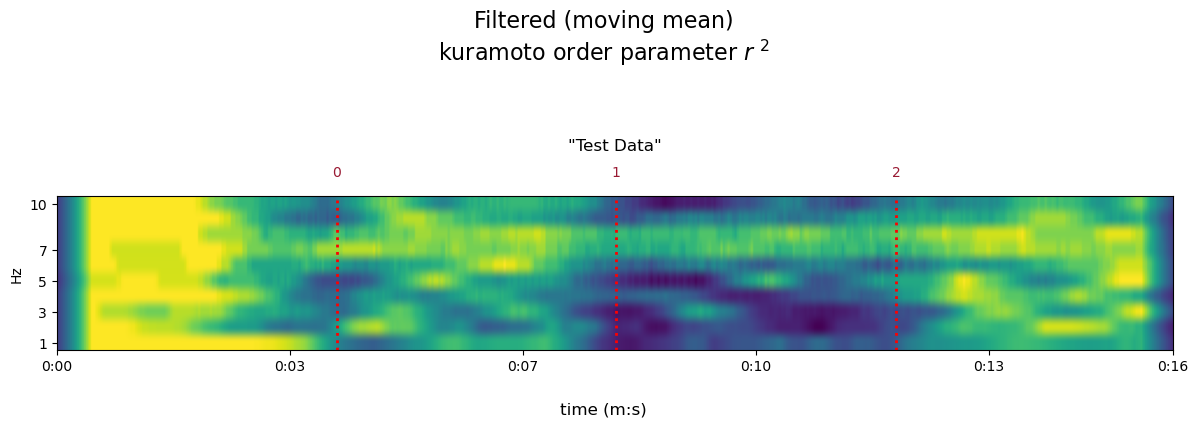

In [15]:
smooth_power = True  # <---

kr_pk = sc.ptdata.kuramoto_r( pks_phase )
kr_pk_vis = kr_pk
if smooth_power:
    kr_pk_s = sc.ptdata.smooth( kr_pk, filter_type='mean', window_size=1 )
    kr_pk_p = sc.ptdata.apply( kr_pk_s, np.power, 2 )
    kr_pk_vis = kr_pk_p
kr_pk_vis.visualise( vscale=1.5 )

>
#### Average for group

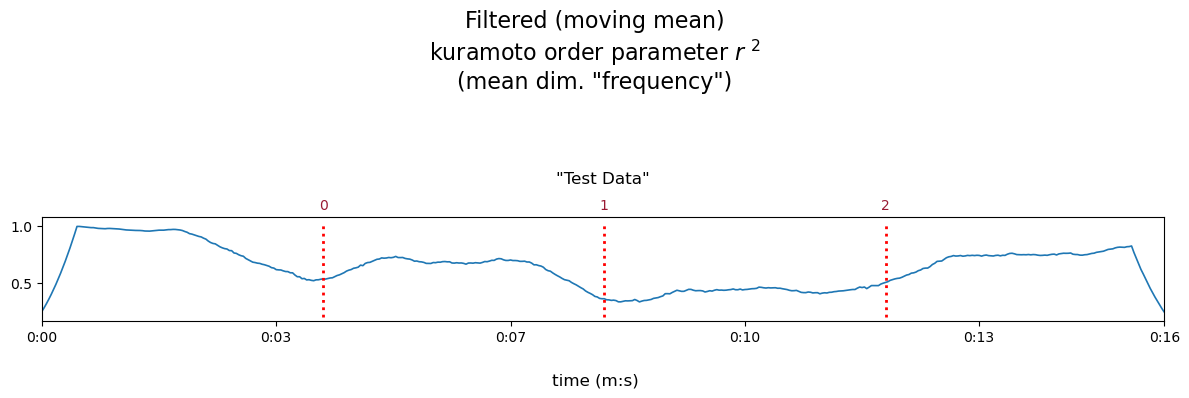

In [16]:
kr_pk_aggr_top = sc.ptdata.aggrax( kr_pk_vis, axis=0, function='mean' )
kr_pk_aggr_top.visualise( vscale=1.3, vistype='line', dlattr='1.2' )

>
#### Sections' statistics

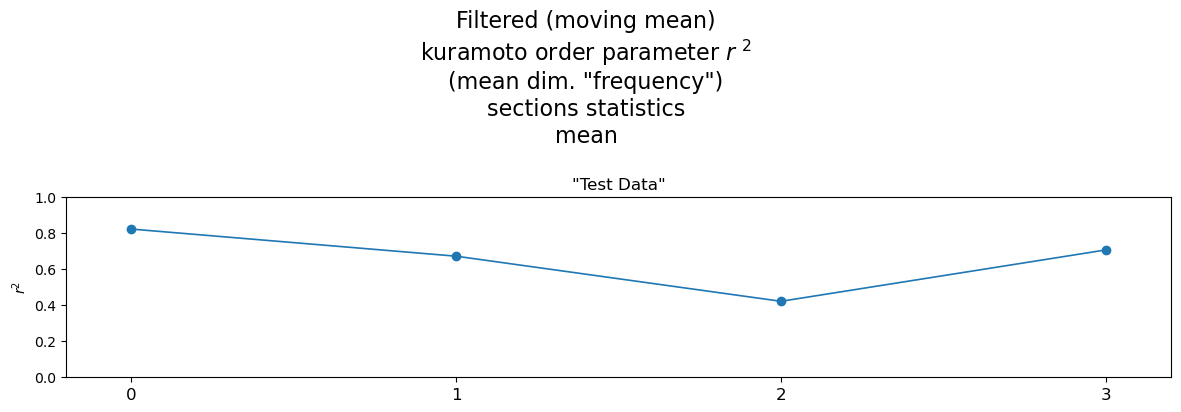

In [17]:

sec_margins = [[0,0.5],[0.5,0.5],[0.5,0.5],[0.5,0]] # <--- sections' margins (seconds)

kr_pk_aggr_top_stats = sc.ptdata.secstats( kr_pk_aggr_top, margins=sec_margins, last=True )
kr_pk_aggr_top_stats.visualise( statistics='mean', vscale=1.2 )

import matplotlib.pyplot as plt
plt.ylim((0,1))
plt.xlim((-0.2,3.2))
plt.xticks((0,1,2,3),('0','1','2','3'),fontsize=12);